In [ ]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 14.2 MB/s eta 0:00:00


In [ ]:

!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics.pairwise import cosine_similarity

from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from nltk.tokenize import RegexpTokenizer
import re

tfidf = TfidfVectorizer(max_features=5000)
stem = StemmerFactory().create_stemmer()
stopword = StopWordRemoverFactory().create_stop_word_remover()

In [ ]:
tourism_with_id = pd.read_csv('tourism_with_idd.csv')
print(tourism_with_id.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_attraction          437 non-null    int64  
 1   name_attraction        437 non-null    object 
 2   price_attraction       437 non-null    int64  
 3   rating_avg_attraction  437 non-null    float64
 4   id_city                437 non-null    int64  
 5   id_attraction_cat      437 non-null    int64  
 6   name_attraction_cat    437 non-null    object 
 7   name_city              437 non-null    object 
 8   desc_attraction        437 non-null    object 
dtypes: float64(1), int64(4), object(4)
memory usage: 30.9+ KB
None


In [ ]:
def preprocessing(data):
    data = data.lower()
    data = stem.stem(data)
    data = stopword.remove(data)
    html_pattern = re.compile('<.*?>')
    data = html_pattern.sub(r'', data)
    tokenizer = RegexpTokenizer(r'\w+')
    data_token = tokenizer.tokenize(data)
    data = " ".join(data_token)
    return data

In [ ]:
data_filtering = tourism_with_id.copy()
data_filtering['Content'] = data_filtering['desc_attraction'] + ' ' + data_filtering['name_attraction_cat']
data_filtering = data_filtering[
    ["id_attraction","name_attraction","Content","name_attraction_cat"]
]
data_filtering

,id_attraction,name_attraction,Content,name_attraction_cat
0,6,Taman Impian Jaya Ancol,Taman Impian Jaya Ancol merupakan sebuah objek...,Taman Hiburan
1,47,Taman Situ Lembang,Taman Situ Lembang adalah sebuah taman kota ya...,Taman Hiburan
2,66,Museum Layang-layang,Museum Layang-Layang adalah sebuah museum yang...,Budaya
3,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya
4,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya
...,...,...,...,...
432,432,Taman Mundu,Taman Mundu merupakan salah satu taman atau ru...,Taman Hiburan
433,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya
434,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan
435,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan


In [ ]:
# with open('tokenizer.pkl', 'wb') as file:
#       pickle.dump(tokenizer, file)
    # with open('tokenizer.pkl', 'rb') as file:
    #   tokenizer = pickle.load(file)

In [ ]:
data_filtering.Content = data_filtering.Content.apply(preprocessing)
data_filtering

,id_attraction,name_attraction,Content,name_attraction_cat
0,6,Taman Impian Jaya Ancol,taman impi jaya ancol rupa buah objek wisata j...,Taman Hiburan
1,47,Taman Situ Lembang,taman situ lembang buah taman kota letak pusat...,Taman Hiburan
2,66,Museum Layang-layang,museum layang buah museum letak jl h kamang no...,Budaya
3,1,Monumen Nasional,monumen nasional populer singkat monas tugu mo...,Budaya
4,2,Kota Tua,kota tua jakarta juga nama kota tua pusat alun...,Budaya
...,...,...,...,...
432,432,Taman Mundu,taman mundu rupa salah satu taman ruang buka h...,Taman Hiburan
433,433,Museum Mpu Tantular,museum negeri mpu tantular buah museum negeri ...,Budaya
434,434,Taman Bungkul,taman bungkul taman wisata kota letak pusat ko...,Taman Hiburan
435,435,Taman Air Mancur Menari Kenjeran,air mancur tari dancing fountain ada kawasan j...,Taman Hiburan


In [ ]:
data_filtering.to_csv("data_filtering.csv", index=False, header=True)

<Axes: >

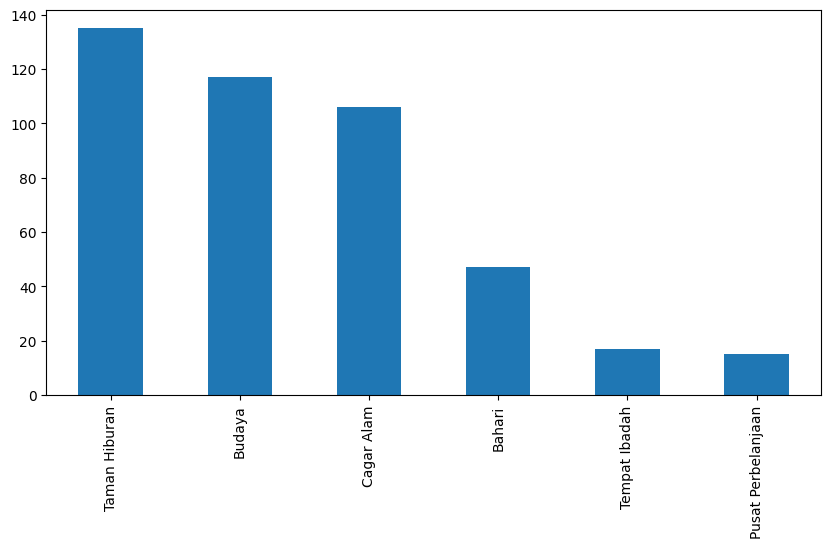

In [ ]:
# Genre distribution
data_filtering['name_attraction_cat'].value_counts().plot(x = 'name_attraction_cat', y ='count', kind = 'bar', figsize = (10,5))


<Axes: title={'center': 'Trigram disribution top 20 words Place Name'}, xlabel='trigram'>

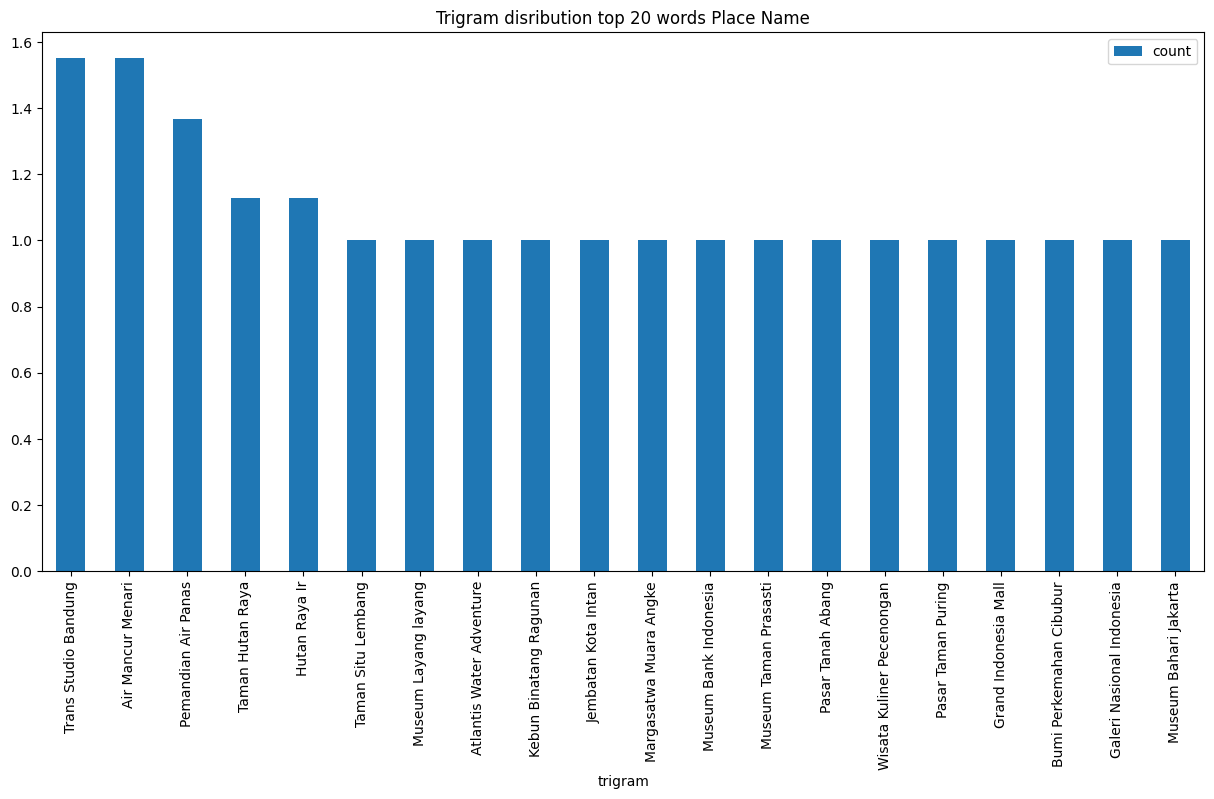

In [ ]:

#Converting text descriptions into vectors using TF-IDF using Trigram
tf = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(data_filtering['name_attraction'])
total_words = tfidf_matrix.sum(axis=0)
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)#converting into dataframe
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True)
#Taking first 20 records
trigram = trigram.head(20)

#Plotting the trigramn distribution
trigram.plot(x ='trigram', y='count', kind = 'bar', title = "Trigram disribution top 20 words Place Name", figsize = (15,7), )


In [ ]:
vectors = tfidf.fit_transform(data_filtering['Content']).toarray()
vectors

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.1695384, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [ ]:
similarity = cosine_similarity(vectors)
similarity[0][1:10]

array([0.18972463, 0.02219708, 0.01497397, 0.03670526, 0.46922383,
       0.14892283, 0.17618366, 0.02137544, 0.10129037])

In [ ]:
def recommend_filtering(nama_tempat):
    # Get the pairwsie similarity scores of all place name with given place name
    nama_tempat_index = data_filtering[data_filtering['name_attraction']==nama_tempat].index[0]
    distancess = similarity[nama_tempat_index]
    # Sort place based on the similarity scores
    nama_tempat_list = sorted(list(enumerate(distancess)),key=lambda x: x[1],reverse=True)[1:20]

    recommended_nama_tempats = []
    for i in nama_tempat_list:
        recommended_nama_tempats.append([data_filtering.iloc[i[0]].name_attraction]+[i[1]])
        # print(nama_tempats.iloc[i[0]].original_title)

    return recommended_nama_tempats

In [ ]:
recommend_filtering('Pantai Watu Kodok')

[['Pantai Kukup', 0.5659440531411729],
 ['Pantai Timang', 0.5185433503874808],
 ['Pantai Drini', 0.5034916444153296],
 ['Pantai Ngandong', 0.48939744234953786],
 ['Pantai Sundak', 0.4855410205632306],
 ['Pantai Ngrawe (Mesra)', 0.4655150705971857],
 ['Pantai Sadranan', 0.449062834411672],
 ['Pantai Jungwok', 0.42546650148837023],
 ['Pantai Cipta', 0.4101023347137378],
 ['Pantai Glagah', 0.3757216172666508],
 ['Pantai Nglambor', 0.36837311443087445],
 ['Pantai Congot', 0.34904230497896804],
 ['Pantai Pok Tunggal', 0.34384697708420525],
 ['Pantai Kesirat', 0.3383368340812807],
 ['Pantai Sedahan', 0.33818120552195025],
 ['Pantai Ancol', 0.3376499329941046],
 ['Pantai Sanglen', 0.33675445374563584],
 ['Pantai Goa Cemara', 0.3341901007750466],
 ['Pantai Indrayanti', 0.334168070919927]]

In [ ]:
# Simpan model ke dalam file
model_file = 'content_based_model.pkl'
with open(model_file, 'wb') as file:
    pickle.dump(similarity, file)